In [140]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns

In [142]:
# upload data 
veg_mw_df = pd.read_excel('data/vegetable-data-MW.xlsx')
fruit_mw_df = pd.read_excel('data/fruit-data-MW.xlsx')
veg_ne_df = pd.read_excel('data/vegetable-data-NE.xlsx')
fruit_ne_df = pd.read_excel('data/fruit-data-NE.xlsx')

In [230]:
# combine dfs
combined_df = pd.concat([veg_mw_df, fruit_mw_df, veg_ne_df, fruit_ne_df], ignore_index=True)

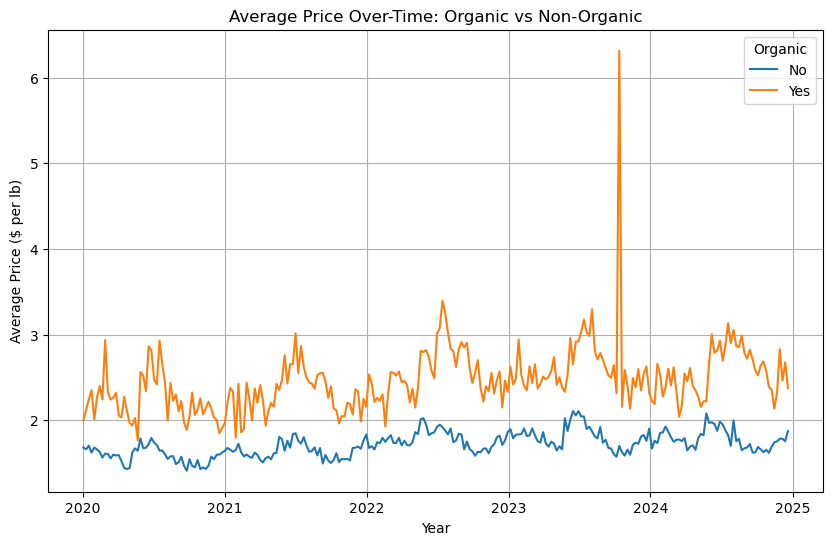

In [232]:
# looking at prices over time (o vs no)
plt.figure(figsize = (10,6))
sns.lineplot(x = "report_date", y = "avg_price",
    hue = "organic", data = price_over_time)

plt.title("Average Price Over-Time: Organic vs Non-Organic")
plt.xlabel("Year")
plt.ylabel("Average Price ($ per lb)")
plt.legend(title = "Organic")
plt.grid(True)
plt.show()

organic
No     29216
Yes     8369
Name: count, dtype: int64


/var/folders/zz/xt3f0n5s1dj8z9tm5p3zvpn80000gn/T/ipykernel_13414/3159852172.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "organic", data = df, palette="Set2")


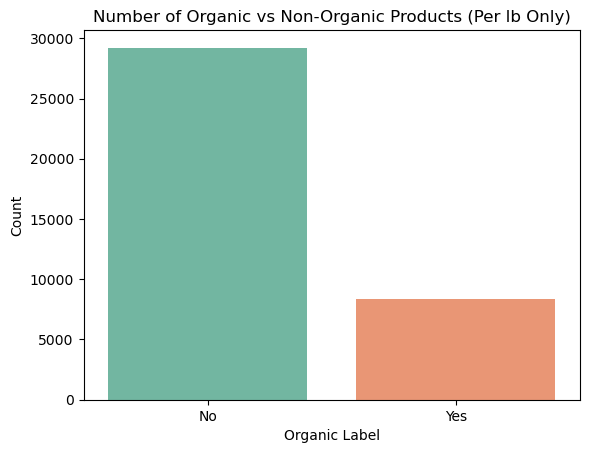

['report_date', 'region', 'product_class', 'commodity', 'variety', 'organic', 'unit', 'environment', 'price_min', 'price_max', 'current_ad_count', 'current_wtd_avg_price', 'priorwk_ad_count', 'priorwk_wtd_avg_price', 'prioryr_ad_count', 'prioryr_wtd_avg_price', 'is_organic']
product_class
Vegetables    19726
Fruit         17859
Name: count, dtype: int64


In [252]:
## setup
# make a copy of df
df = combined_df.copy()
df = df.rename(columns = {"class": "product_class"})

# make organic binary
df["organic"] = df["organic"].astype(str).str.strip().str.title().replace({"True":"Yes","False":"No"})
df["is_organic"] = (df["organic"] == "Yes").astype(int)

# control unit of measurment
df["unit"] = df["unit"].astype(str).str.strip().str.lower()
df = df[df["unit"] == "per lb"]

# count organic number
counts = df["organic"].value_counts(dropna=False)
print(counts)

# visualize
sns.countplot(x = "organic", data = df, palette="Set2")
plt.title("Number of Organic vs Non-Organic Products (Per lb Only)")
plt.xlabel("Organic Label")
plt.ylabel("Count")
plt.show()

# look at column names
print(df.columns.tolist())

# count product classes
print(df["product_class"].value_counts())

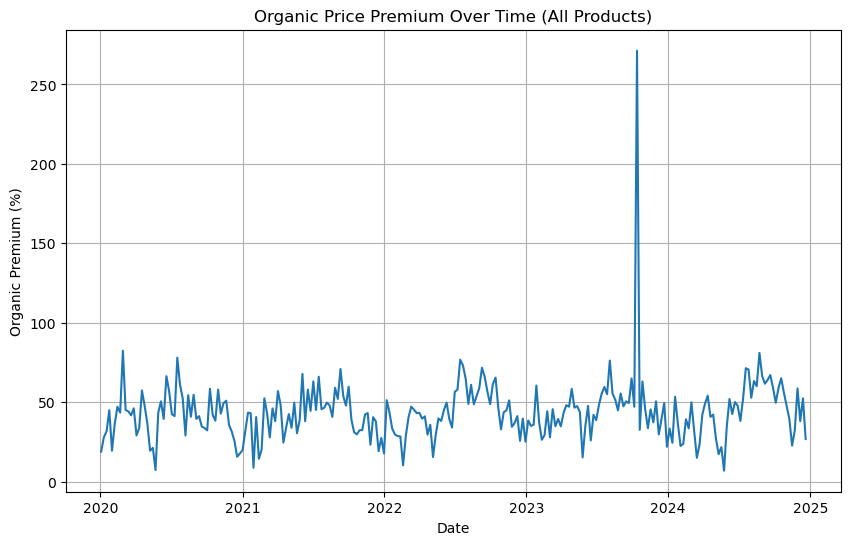

                             OLS Regression Results                            
Dep. Variable:     organic_premium_pct   R-squared:                       0.017
Model:                             OLS   Adj. R-squared:                  0.013
Method:                  Least Squares   F-statistic:                     4.400
Date:                 Wed, 12 Nov 2025   Prob (F-statistic):             0.0369
Time:                         09:48:12   Log-Likelihood:                -1142.6
No. Observations:                  259   AIC:                             2289.
Df Residuals:                      257   BIC:                             2296.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.3554      2.485     15.83

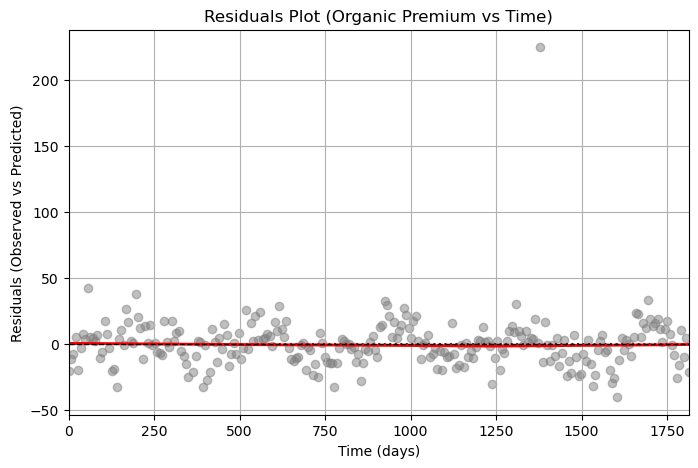

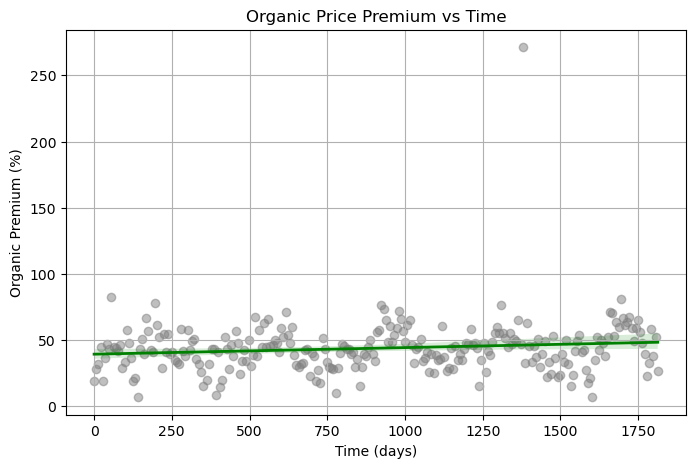

In [254]:
## analysis of price premiums 
# normalize
df["report_date"] = pd.to_datetime(df["report_date"], errors = "coerce")
df = df.dropna(subset = ["report_date", "current_wtd_avg_price"])

# average price of organic and non-organic products for each date
price_over_time = (
    df.groupby(["report_date", "organic"], as_index = False)["current_wtd_avg_price"]
      .mean().rename(columns = {"current_wtd_avg_price": "avg_price"}))

# create df
premium_df = (
    price_over_time.pivot(index = "report_date", columns = "organic", values = "avg_price")
    .reset_index())

# calcuate premium
premium_df["organic_premium_pct"] = (
    (premium_df["Yes"] - premium_df["No"]) / premium_df["No"] * 100)

# visualize premium overtime
plt.figure(figsize = (10,6))
sns.lineplot(x = "report_date", y = "organic_premium_pct", data = premium_df)
plt.title("Organic Price Premium Over Time (All Products)")
plt.ylabel("Organic Premium (%)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

# remove nas
premium_df = premium_df.dropna(subset = ["organic_premium_pct"])

# make time variable
premium_df["time_index"] = (premium_df["report_date"] - premium_df["report_date"].min()).dt.days

# regression model - has organic price premium has increased or decreased over time?
model1 = smf.ols(
    formula = "organic_premium_pct ~ time_index",
    data = premium_df).fit()

# print
print(model1.summary())

# resiudals plot 
plt.figure(figsize = (8,5))
sns.residplot(
    x = "time_index", y = "organic_premium_pct",
    data = premium_df,lowess = True,
    scatter_kws = {'alpha':0.5, 'color':'gray'},
    line_kws = {'color':'red', 'lw':2})

# residual labels
plt.title("Residuals Plot (Organic Premium vs Time)")
plt.xlabel("Time (days)")
plt.ylabel("Residuals (Observed vs Predicted)")
plt.axhline(0, color = "black", linestyle = "--", linewidth=1)
plt.grid(True)
plt.show()

# scatterplot w fiited regression line
plt.figure(figsize = (8,5))
sns.regplot(x = "time_index", y = "organic_premium_pct",
    data = premium_df,
    scatter_kws = {'alpha':0.5, 'color':'gray'}, line_kws={'color':'green', 'linewidth':2})

# scatterplot labels
plt.title("Organic Price Premium vs Time")
plt.xlabel("Time (days)")
plt.ylabel("Organic Premium (%)")
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:       current_ad_count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     812.5
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:43:01   Log-Likelihood:            -2.7924e+05
No. Observations:               37585   AIC:                         5.585e+05
Df Residuals:                   37581   BIC:                         5.585e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

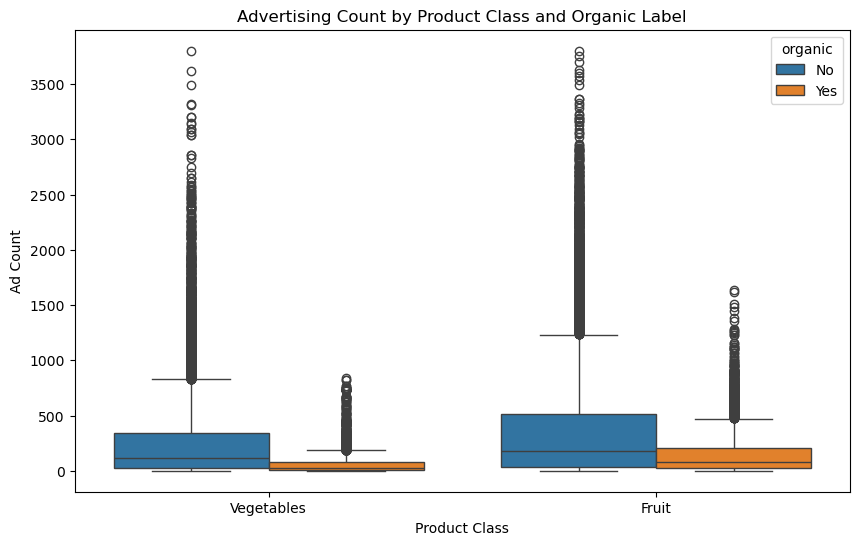

In [240]:
## analysis of relationship with ad numbers
# regression model - do organic products have more ads (control for product_class and region)?
model2 = smf.ols(
    formula = "current_ad_count ~ is_organic  + C(product_class) + C(region)",
    data = df).fit()

# print
print(model2.summary())

# boxplot (separated by fruits/vegetables)
plt.figure(figsize = (10,6))
sns.boxplot(x = "product_class", y = "current_ad_count",
    hue = "organic", data = df)

# boxplot labels
plt.title("Advertising Count by Product Class and Organic Label")
plt.ylabel("Ad Count")
plt.xlabel("Product Class")
plt.show()